## Install

In [ ]:
!pip install python-doctr
!pip install "python-doctr[tf]"
!pip install "python-doctr[torch]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.1/289.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install -q timm pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (8,619 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
# !pip install reportlab

In [ ]:
# !pip install PyPDF2

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from PIL import Image, ImageDraw
from doctr.io import DocumentFile
from doctr.io.elements import Block, Document, KIEDocument, KIEPage, Line, Page, Prediction, Word
from doctr.models import ocr_predictor
from google.colab.patches import cv2_imshow

from __future__ import print_function
import torch
import cv2

In [ ]:
from doctr.utils.geometry import resolve_enclosing_bbox
from doctr.models import builder
from doctr.models import detection_predictor

In [ ]:
import pytesseract
from pytesseract import Output

In [ ]:
# from reportlab.pdfgen.canvas import Canvas
# from reportlab.lib.pagesizes import A4
# from reportlab.pdfbase import pdfmetrics
# from reportlab.pdfbase.ttfonts import TTFont
# from io import BytesIO

In [ ]:
!wget https://github.com/tesseract-ocr/tessdata/raw/main/ukr.traineddata

--2024-05-31 19:52:00--  https://github.com/tesseract-ocr/tessdata/raw/main/ukr.traineddata
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/ukr.traineddata [following]
--2024-05-31 19:52:00--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/ukr.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12408644 (12M) [application/octet-stream]
Saving to: ‘ukr.traineddata’

ukr.traineddata     100%[===================>]  11.83M  --.-KB/s    in 0.1s    

2024-05-31 19:52:00 (109 MB/s) - ‘ukr.traineddata’ saved [12408644/12408644]



## func

In [ ]:
def calculate_overlap_area(block1, block2):
    # Calculate the overlap area between two blocks
    x_overlap = max(0, min(block1[2], block2[2]) - max(block1[0], block2[0]))
    y_overlap = max(0, min(block1[3], block2[3]) - max(block1[1], block2[1]))
    overlap_area = x_overlap * y_overlap
    return overlap_area

def filter_blocks_th(blocks, threshold=0.9):
    # Filter out blocks that are almost entirely inside other blocks
    blocks_to_remove = set()
    for i, block1 in enumerate(blocks):
        for j, block2 in enumerate(blocks):
            if i != j and j not in blocks_to_remove:
                overlap_area = calculate_overlap_area(block1, block2)
                area1 = (block1[2] - block1[0]) * (block1[3] - block1[1])
                if overlap_area / area1 > threshold:
                    blocks_to_remove.add(i)
                    break
    filtered_blocks = [block for i, block in enumerate(blocks) if i not in blocks_to_remove]
    return filtered_blocks

In [ ]:
def makeDir(name):
    if os.path.exists(name) is False:
        os.mkdir(name)
    else:
        for filename in os.listdir(name):
            if os.path.isfile(os.path.join(name, filename)):
                os.remove(os.path.join(name, filename))

In [ ]:
def is_inside(box1, box2):
    x1, y1, x2, y2 = box1
    xx1, yy1, xx2, yy2 = box2
    return x1 > xx1 and y1 > yy1 and x2 < xx2 and y2 <= yy2

# def is_inside_wh(box1, box2):
#     x1, y1, w1, h1 = box1
#     xx1, yy1, w2, h2 = box2
#     xx2 = xx1+w2
#     yy2 = yy1+h2
#     x2 = x1+w2
#     y2 = y1+h2
#     return (x1 > xx1 and y1 > yy1 and x2 < xx2 and y2 <= yy2).all()

def filter_boxes(boxes):
    filtered_boxes = []
    for i, box1 in enumerate(boxes):
        is_inside_another = False
        for j, box2 in enumerate(boxes):
            if i != j and is_inside(box1, box2):
                is_inside_another = True
                break
        if not is_inside_another:
            filtered_boxes.append(box1)
    return filtered_boxes

# def filter_boxes_wh(boxes):
#     filtered_boxes = []
#     for i, box1 in enumerate(boxes):
#         is_inside_another = False
#         for j, box2 in enumerate(boxes):
#             if i != j and is_inside_wh(box1, box2):
#                 is_inside_another = True
#                 break
#         if not is_inside_another:
#             filtered_boxes.append(box1)
#     return filtered_boxes

In [ ]:
def nms_pytorch(P : torch.tensor ,thresh_iou : float):
    # we extract coordinates for every
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]

    # we extract the confidence scores as well
    scores = P[:, 4]

    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)

    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()

    # initialise an empty list for
    # filtered prediction boxes
    keep = []


    while len(order) > 0:

        # extract the index of the
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]

        # push S in filtered predictions list
        keep.append(P[idx])

        # remove S from P
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            break

        # select coordinates of BBoxes according to
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1

        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        # find the intersection area
        inter = w*h

        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order)

        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]

        # find the IoU of every prediction in P with S
        IoU = inter / union

        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]

    return keep

In [ ]:
def load_images_from_folder(folder):
    image_paths = []
    for filename in os.listdir(folder):
        image_paths.append(os.path.join(folder, filename))
    return image_paths

In [ ]:
def create_heatmap(bounding_boxes_list):
     heatmap = np.zeros(shape=(image.size[1], image.size[0]))
     for bounding_box in bounding_boxes_list:
          heatmap[int(bounding_box[1]):int(bounding_box[3]), int(bounding_box[0]):int(bounding_box[2])] += bounding_box[4]

     return heatmap

In [ ]:
def images_to_pdf(directory):
    pil_images = []
    convert_pil_images = []

    for filename in os.listdir(directory):
        if filename != ".ipynb_checkpoints" and filename != "result.pdf":
            pil_images.append(Image.open(directory + "/" + filename))

    for pil_image in pil_images:
        convert_pil_images.append(pil_image.convert('RGB'))

    image_list = convert_pil_images[1:]

    convert_pil_images[0].save(f"{directory}/result.pdf", save_all = True, append_images = image_list)

## File upload

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content
!mkdir tables_data
!cp -r "/content/drive/MyDrive/Colab Notebooks/tables_data/data_ua.zip" "/content/tables_data/"

/content


In [ ]:
# Unzip data
!unzip /content/tables_data/data_ua -d /content/

Archive:  /content/tables_data/data_ua.zip
   creating: /content/data/
  inflating: /content/data/click_coordinates.csv  
   creating: /content/data/images/
  inflating: /content/data/images/1.jpg  
  inflating: /content/data/images/10.jpg  
  inflating: /content/data/images/11.jpg  
  inflating: /content/data/images/12.jpg  
  inflating: /content/data/images/13.jpg  
  inflating: /content/data/images/14.jpg  
  inflating: /content/data/images/15.jpg  
  inflating: /content/data/images/16.jpg  
  inflating: /content/data/images/17.jpg  
  inflating: /content/data/images/18.jpg  
  inflating: /content/data/images/19.jpg  
  inflating: /content/data/images/2.jpg  
  inflating: /content/data/images/20.jpg  
  inflating: /content/data/images/21.jpg  
  inflating: /content/data/images/23.jpg  
  inflating: /content/data/images/24.jpg  
  inflating: /content/data/images/26.jpg  
  inflating: /content/data/images/27.jpg  
  inflating: /content/data/images/28.jpg  
  inflating: /content/data/i

In [ ]:
%cd /content
!mkdir -p data
!cp -r "/content/drive/MyDrive/Colab Notebooks/tables_data/locations.zip" "/content/data/"

/content


In [ ]:
# Unzip data
!unzip /content/data/locations -d /content/data/

In [ ]:
%cd /content
!mkdir -p data
# !mkdir tables_data
!cp -r "/content/drive/MyDrive/Colab Notebooks/tables_data/images.zip" "/content/data/"

/content


In [ ]:
# Unzip data
!unzip /content/text_images -d /content/

In [ ]:
makeDir('check')

In [ ]:
# Unzip data
!rm -rf /content/dataset
!unzip /content/dataset -d /content/

## data

In [ ]:
# true_data = pd.read_csv('/content/tables_data/data/click_coordinates.csv')

In [ ]:
# makeDir('text_images')
folder = '/content/data/images'
# folder = '/content/text_images'
# folder = '/content/data/images'
# folder = '/content/check'

# image_paths = load_images_from_folder(folder)

In [ ]:
# image_names = true_data['image_name'].tolist()
image_paths = load_images_from_folder(folder)
image_names = []
for im in image_paths:
  img_name = os.path.basename(im)
  image_names.append(img_name)

In [ ]:
image_names

['53.jpg',
 '40.jpg',
 '41.jpg',
 '31.jpg',
 '17.jpg',
 '16.jpg',
 '9.jpg',
 '3.jpg',
 '72.jpg',
 '66.jpg',
 '46.jpg',
 '60.jpg',
 '49.jpg',
 '45.jpg',
 '1.jpg',
 '74.jpg',
 '64.jpg',
 '26.jpg',
 '24.jpg',
 '61.jpg',
 '65.jpg',
 '8.jpg',
 '69.jpg',
 '63.jpg',
 '73.jpg',
 '11.jpg',
 '28.jpg',
 '56.jpg',
 '59.jpg',
 '68.jpg',
 '76.jpg',
 '35.jpg',
 '39.jpg',
 '55.jpg',
 '36.jpg',
 '34.jpg',
 '71.jpg',
 '21.jpg',
 '14.jpg',
 '75.jpg',
 '62.jpg',
 '6.jpg',
 '2.jpg',
 '57.jpg',
 '42.jpg',
 '30.jpg',
 '47.jpg',
 '7.jpg',
 '20.jpg',
 '4.jpg',
 '19.jpg',
 '67.jpg',
 '18.jpg',
 '48.jpg',
 '38.jpg',
 '43.jpg',
 '13.jpg',
 '50.jpg',
 '32.jpg',
 '77.jpg',
 '27.jpg',
 '15.jpg',
 '10.jpg',
 '54.jpg',
 '70.jpg',
 '37.jpg',
 '29.jpg',
 '58.jpg',
 '23.jpg',
 '33.jpg',
 '12.jpg',
 '52.jpg',
 '44.jpg',
 '5.jpg',
 '51.jpg']

## Blocks

# short

In [ ]:
document = DocumentFile.from_images(image_paths)
result = model(document)

In [ ]:
json_output = result.export()

In [ ]:
index_names = [2]
save_folder = '/content/data/data_modified'
i=0
# for i in index_names:
for page in result.pages:
  # file_path = f'{folder}/{image_names[i]}'
  # document = DocumentFile.from_images(file_path)
  # result = model(document)

  # # json_output = result.export()

  # page = result.pages[0]

  file_path = image_paths[i]
  blocks = page.blocks
  dims = page.dimensions

  image = Image.open(file_path)
  doctr_coord_blocks = []
  doctr_coord_blocks_first = []

  for b in blocks:
      coord = b.geometry
      x1, y1, x2, y2 = coord[0][0]*dims[1], coord[0][1]*dims[0], coord[1][0]*dims[1], coord[1][1]*dims[0]
      doctr_coord_blocks.append([x1, y1, x2, y2])
      doctr_coord_blocks_first.append([x1, y1, x2, y2])

  doctr_coord_blocks = filter_boxes(doctr_coord_blocks)
  predictions = torch.tensor([(x1, y1, x2, y2, (x2 - x1) * (y2 - y1)) for [x1, y1, x2, y2] in doctr_coord_blocks])
  filtered_boxes = nms_pytorch(predictions,thresh_iou=0.01)

  image_nms = Image.open(file_path)
  draw_nms = ImageDraw.Draw(image_nms)

  for [x1, y1, x2, y2] in doctr_coord_blocks_first:
      draw_nms.rectangle([x1, y1, x2, y2], outline='blue', width=2)
  for [x1, y1, x2, y2] in doctr_coord_blocks:
      draw_nms.rectangle([x1, y1, x2, y2], outline='green', width=2)
  for b in filtered_boxes:
      b = list(map(float, b))
      draw_nms.rectangle([b[0], b[1], b[2], b[3]], outline='red', width=2)

  output_path = f'{save_folder}/{image_names[i]}'
  image_nms.save(output_path)
  i+=1



In [ ]:
json_output

In [ ]:
import unidecode
import json
# doc_json = unidecode.unidecode('result.json').lower().replace(' - ','_').replace(' ','_').replace('.pdf','.json')
path_to_doc_json = '/content/data/result.json'
with open(path_to_doc_json, 'w') as json_file:
    json.dump(json_output, json_file)

# full

In [ ]:
index_name = 1

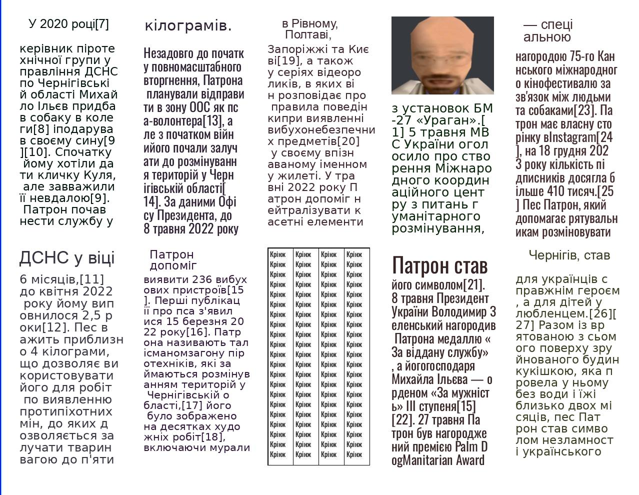

In [ ]:
file_path = f'{folder}/{image_names[index_name]}'
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [ ]:
height

990

In [ ]:
document = DocumentFile.from_images(file_path)

In [ ]:
result = model_ocr(document)

In [ ]:
page = result.pages[0]
blocks = page.blocks
dims = page.dimensions

In [ ]:
dims

(990, 1278)

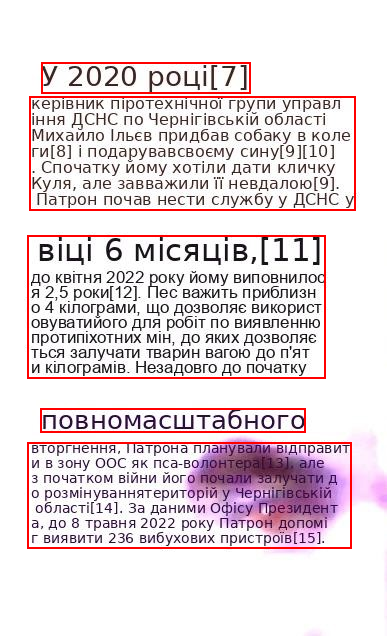

In [ ]:
image = Image.open(file_path)
draw = ImageDraw.Draw(image)
doctr_coord_blocks = []
doctr_coord_blocks_first = []

for b in blocks:
    coord = b.geometry
    x1, y1, x2, y2 = coord[0][0]*dims[1], coord[0][1]*dims[0], coord[1][0]*dims[1], coord[1][1]*dims[0]
    doctr_coord_blocks.append([x1, y1, x2, y2])
    doctr_coord_blocks_first.append([x1, y1, x2, y2])
    draw.rectangle([x1, y1, x2, y2], outline='red', width=2)

display(image)

In [ ]:
# image_one = Image.open(file_path)
# draw_one = ImageDraw.Draw(image_one)
# draw_one.rectangle(doctr_coord_blocks[10], outline='red', width=2)

# display(image_one)

In [ ]:
# doctr_coord_blocks.remove()

In [ ]:
def is_inside(box1, box2):
    x1, y1, x2, y2 = box1
    xx1, yy1, xx2, yy2 = box2
    return x1 > xx1 and y1 > yy1 and x2 < xx2 and y2 <= yy2

def filter_boxes(boxes):
    filtered_boxes = []
    for i, box1 in enumerate(boxes):
        is_inside_another = False
        for j, box2 in enumerate(boxes):
            if i != j and is_inside(box1, box2):
                is_inside_another = True
                break
        if not is_inside_another:
            filtered_boxes.append(box1)
    return filtered_boxes

doctr_coord_blocks = filter_boxes(doctr_coord_blocks)

# print("Original Boxes:", doctr_coord_blocks)
# print("Filtered Boxes:", fil_boxes)


In [ ]:
blocks[0].geometry

In [ ]:
# blocks_coord = np.array([b.geometry for b in blocks])
# print(blocks_coord)

In [ ]:
predictions = torch.tensor([(x1, y1, x2, y2, (x2 - x1) * (y2 - y1)) for [x1, y1, x2, y2] in doctr_coord_blocks])

In [ ]:
predictions[:, 0]

In [ ]:
filtered_boxes = nms_pytorch(predictions,thresh_iou=0.015)

In [ ]:
len(filtered_boxes)

5

In [ ]:
filtered_boxes

In [ ]:
len(predictions)

5

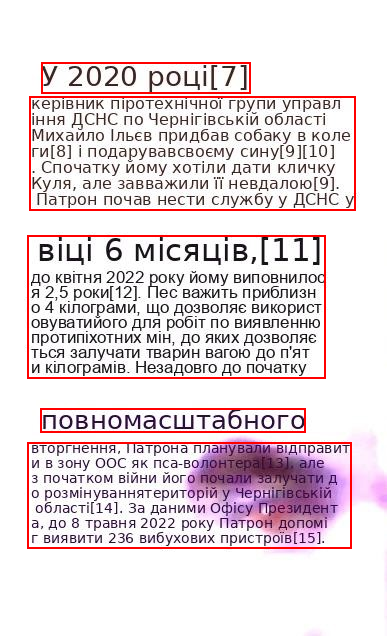

In [ ]:
image_nms = Image.open(file_path)
draw_nms = ImageDraw.Draw(image_nms)
save_folder = '/content/data/data_modified'

for [x1, y1, x2, y2] in doctr_coord_blocks_first:
    draw_nms.rectangle([x1, y1, x2, y2], outline='blue', width=2)
for [x1, y1, x2, y2] in doctr_coord_blocks:
    draw_nms.rectangle([x1, y1, x2, y2], outline='green', width=2)
for b in filtered_boxes:
    b = list(map(float, b))
    draw_nms.rectangle([b[0], b[1], b[2], b[3]], outline='red', width=2)

output_path = f'{save_folder}/{image_names[index_name]}'
image_nms.save(output_path)
display(image_nms)

# resolve

In [ ]:
# model = detection_predictor('db_resnet50', pretrained=True)
model2 = detection_predictor('linknet_resnet18', pretrained=True)

In [ ]:
# image_paths_check = load_images_from_folder('/content/check')
document = DocumentFile.from_images(image_paths)
result = model2(document)

In [ ]:
# result[0]
words = result[0]['words']
words[:, :, 0]

array([[0.6796875 , 0.7324219 , 0.7324219 , 0.6796875 ],
       [0.74121094, 0.94921875, 0.94921875, 0.74121094],
       [0.18164062, 0.18945312, 0.18945312, 0.18164062],
       ...,
       [0.31302428, 0.31369483, 0.18209293, 0.18142238],
       [0.3515625 , 0.3623047 , 0.3623047 , 0.3515625 ],
       [0.1695824 , 0.17008665, 0.0647926 , 0.06428835]], dtype=float32)

In [ ]:
result

[{'words': array([[0.6796875 , 0.86132812, 0.734375  , 0.87597656, 0.66741043],
         [0.74121094, 0.85742188, 0.95117188, 0.87792969, 0.59570694],
         [0.18164062, 0.85839844, 0.19140625, 0.8671875 , 0.10420629],
         ...,
         [0.18164062, 0.078125  , 0.31640625, 0.109375  , 0.65466213],
         [0.3515625 , 0.08300781, 0.36425781, 0.10449219, 0.69852018],
         [0.06542969, 0.07910156, 0.171875  , 0.10449219, 0.72123873]])}]

## full

In [ ]:
makeDir('check')

In [ ]:
for i in range(3):
  words = result[i]['words']

  image = Image.open(image_paths[i])
  width, height = image.size
  words_dim = []
  for [x1, y1, x2, y2, t] in words:
      words_dim.append([x1*width, y1*height, x2*width, y2*height, t])

  draw = ImageDraw.Draw(image)
  width, height = image.size
  # data = []
  for [x1, y1, x2, y2, t] in words_dim:
      draw.rectangle([x1, y1, x2, y2], outline='green', width=2)
      # text = pytesseract.image_to_string(img_crop, lang="ukr", config="--psm 6")
      # data = data.append({'image_path': image_paths[i], 'block_coord': [x1, y1, x2, y2], 'text': text}, ignore_index=True)
  # blocks_coord.append([i, blocks_boxes])
  img_name = os.path.basename(image_paths[i+15])
  image.save(f'/content/check/{img_name}')

IndexError: list index out of range

In [ ]:
img_name = '29.jpg'
image = Image.open(f'/content/check/{img_name}')
display(image)

### dbscan

In [ ]:
# from sklearn.cluster import dbscan
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.datasets import make_moons
from queue import Queue

In [ ]:
blobs = make_moons(500, noise=0.055)[0]
words = result[0]['words']
words_dim = []
for [x1, y1, x2, y2, t] in words:
      image = Image.open(image_paths[0])
      width, height = image.size
      x = (x1+x2)/2
      y = (y1+y2)/2
      words_dim.append([y*height, x*width])
      words_dim.append([y*height, x1*width])
      words_dim.append([y*height, x2*width])
      # words_dim.append([x*height, y*width])
      # words_dim.append([x1*height, y*width])
      # words_dim.append([x2*height, y*width])
      # words_dim.append([y1*height, x1*width])
      # words_dim.append([y2*height, x2*width])
      # words_dim.append([y1*height, x2*width])
      # words_dim.append([y2*height, x1*width])
# words_dim
words_dim = np.array(words_dim)

In [ ]:
words_dim[0]
# blobs

In [ ]:
db = DBSCAN(eps=0.2, min_samples=5).fit(words_dim)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

In [ ]:
# Create Blobs
blobs = make_moons(500, noise=0.055)[0]
blobs = words_dim.copy()

# Standardized the data
for x in range(2):
    m = blobs[:,x].mean()
    s = blobs[:,x].std()
    for y in range(len(blobs)):
        blobs[y,x] = (blobs[y,x] - m)/s

#Plot
plt.style.use("bmh")
fig, ax = plt.subplots(1, 3, dpi=250)
fig.suptitle("DBSCAN Can Correctly Label Arbitrary Shaped Clusters", fontsize=20)

# Scikit-Learn DBSCAN
# preds = dbscan(blobs)[1]
# preds = dbscan(blobs, eps=0.2, min_samples=5)#.fit(blobs)
preds = DBSCAN(eps=0.2, min_samples=2).fit_predict(blobs)
dbscan_blob = np.append(blobs, preds.reshape(-1,1), axis=1)
pd.DataFrame(dbscan_blob).plot(x=1, y=0, kind="scatter", c=2, colorbar=False, ax=ax[1], title= "Scikit-Learn DBSCAN (eps=0.2, min_points=5)", marker="+", colormap="tab20b")

# Test Data
pd.DataFrame(blobs).plot(x=1, y=0, kind="scatter", ax=ax[0], alpha=0.5, figsize=(15,6), title="Test Data", marker="+", c="#e377c0")
plt.show()

In [ ]:
words[0]

In [ ]:
words

In [ ]:
blobs[0]

### heatmap

In [ ]:
os.environ['TESSDATA_PREFIX'] = '.'

In [ ]:
blocks_coord = []
data = pd.DataFrame(columns=['image_path', 'block_coord', 'text'])
makeDir('result_doc')
for i in range(len(result)):
# for i in range(3):
  # document = DocumentFile.from_images(image_paths[i])
  # result = model(document)
  words = result[i]['words']

  image = Image.open(image_paths[i])
  width, height = image.size
  words_dim = []
  for [x1, y1, x2, y2, t] in words:
      words_dim.append([x1*width, y1*height, x2*width, y2*height, t])

  img = cv2.imread(image_paths[i])
  hm = create_heatmap(words_dim)

  heatmap = cv2.resize(hm, (img.shape[1], img.shape[0]))
  heatmapshow = None
  heatmapshow = cv2.normalize(heatmap, heatmapshow, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_HOT)

  gray = cv2.cvtColor(heatmapshow, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

  ksize = (8, 8)
  thresh = cv2.blur(thresh, ksize)

  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  image_final = Image.open(image_paths[i])
  draw = ImageDraw.Draw(image_final)
  width, height = image_final.size

  # cnts = filter_boxes_wh(cnts)
  blocks_boxes = []
  for c in cnts:
      x,y,w,h = cv2.boundingRect(c)
      blocks_boxes.append([x, y, x + w, y + h])

  # blocks_boxes = filter_boxes(blocks_boxes)
  blocks_boxes = filter_blocks_th(blocks_boxes, threshold=0.85)
  # data = []
  for [x1, y1, x2, y2] in blocks_boxes:
      draw.rectangle([x1, y1, x2, y2], outline='green', width=2)
      img_crop = image_final.crop((x1, y1, x2, y2))
      text = pytesseract.image_to_string(img_crop, lang="ukr", config="--psm 6")
      data = data.append({'image_path': image_paths[i], 'block_coord': [x1, y1, x2, y2], 'text': text}, ignore_index=True)
  # blocks_coord.append([i, blocks_boxes])
  img_name = os.path.basename(image_paths[i])
  image_final.save(f'/content/result_doc/{img_name}')

<ipython-input-27-2e07f0236834>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'image_path': image_paths[i], 'block_coord': [x1, y1, x2, y2], 'text': text}, ignore_index=True)
<ipython-input-27-2e07f0236834>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'image_path': image_paths[i], 'block_coord': [x1, y1, x2, y2], 'text': text}, ignore_index=True)
<ipython-input-27-2e07f0236834>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'image_path': image_paths[i], 'block_coord': [x1, y1, x2, y2], 'text': text}, ignore_index=True)
<ipython-input-27-2e07f0236834>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

In [ ]:
# images_to_pdf('/content/result_doc')

In [ ]:
blocks_coord

[]

In [ ]:
# data[data['image_path'] == /content/data/dataset/result/28.jpg]
data

,image_path,block_coord,text
0,/content/text_images/30-01-2024_21-32-53_75095...,"[19, 1493, 338, 1682]",очали залучати до ро\nзмінування територій\nу ...
1,/content/text_images/30-01-2024_21-32-53_75095...,"[726, 407, 1067, 1689]","службу», а його госпо\nдаря Михайла Ільєва -\n..."
2,/content/text_images/30-01-2024_21-32-53_75095...,"[18, 392, 372, 1490]",групи управління ДСНС\nпо Чернігівській обл\nа...
3,/content/text_images/30-01-2024_21-32-53_75095...,"[835, 233, 969, 352]",медаллІю\nБіл\nлддану\n
4,/content/text_images/30-01-2024_21-32-53_75095...,"[752, 231, 834, 334]",РШ»М\n
5,/content/text_images/30-01-2024_21-32-53_75095...,"[751, 162, 906, 229]",
6,/content/text_images/30-01-2024_21-32-53_75095...,"[908, 154, 985, 217]",
7,/content/text_images/30-01-2024_21-32-53_75095...,"[373, 154, 725, 1655]",К тРАвНЯ 7072 РОКУ ПАТРО\n\nИ ДОПОМІГ ВИЯВИТИ ...
8,/content/text_images/30-01-2024_21-32-53_75095...,"[25, 147, 345, 307]",У 2020 роціЇ7\n1 керівникп\nіротехнічної\n


In [ ]:
data.to_csv('/content/data.csv')

In [ ]:
pdfmetrics.registerFont(TTFont('DejaVuSerif', 'DejaVuSerif.ttf'))
pdf_buffers = []

for image_path in image_paths:
  print(f'{os.path.basename(image_path)}')
  buffer = BytesIO()
  coord_list = data[data['image_path'] == image_path]['block_coord'].tolist()
  txt_list = data[data['image_path'] == image_path]['text'].tolist()

  im = Image.open(image_path)
  ps=(im.size[0],im.size[1])
  white_layer = Image.new('RGB', im.size, (255, 255, 255, int(255 * 0.85)))
  im = Image.blend(im, white_layer, 0.85)

  canvas = Canvas(buffer, pagesize=ps)
  canvas.setFont('DejaVuSerif', 15)
  canvas.drawInlineImage(im,x=0, y=0, width=im.size[0], height=im.size[1])
  for coord, txt in zip(coord_list, txt_list):

    textobject = canvas.beginText(coord[0], im.size[1]-coord[1])

    l = len(txt.splitlines())
    lead = (coord[3] - coord[1])/l
    # print(lead)
    textobject.setLeading(lead)
    for line in txt.splitlines(False):
        textobject.textLine(line.rstrip())
    canvas.drawText(textobject)
  canvas.save()
  buffer.seek(0)  # Reset buffer position to the beginning
  pdf_buffers.append(buffer)
    # canvas.save()

In [ ]:
from PyPDF2 import PdfMerger
merger = PdfMerger()

for pdf_buffer in pdf_buffers:
    merger.append(pdf_buffer)

# Save the merged PDF to Colab's file system
output_pdf_path = "/content/merged_pdf.pdf"
merger.write(output_pdf_path)
merger.close()

In [ ]:
from PIL import Image, ImageEnhance

img = Image.open(image_paths[1])
white_layer = Image.new('RGB', img.size, (255, 255, 255, int(255 * 0.85)))
# white_layer = white_layer.resize(img.size)
blended_img = Image.blend(img, white_layer, 0.85)
display(blended_img)


## tesseract

In [ ]:
os.environ['TESSDATA_PREFIX'] = '.'

In [ ]:
image_pt = Image.open(image_paths[0])
text = pytesseract.image_to_string(image_pt, lang="ukr", config="--psm 6")

In [ ]:
print(text)

ИИ 7070 РШМ 7 КВР%НЩ( ифщшщаинт
?ум И«Рд(:щщь“ь Огоранення, Патрона. плянувлли В ;%::';:д::иї";р те
щ дправити 6 зону О0С як пса-волон про створення
%ЕНЕБЦЗ.:ЗЕ;НЙ;;ЕЕЗК тера|«3), але з похатком Війни ї Міжиарпдь-я;гп
льєв придбав собак координаційног
Зрсвнелени ві ї поб оо потали здлулати фо рагмшМл о центру а пи
ЗІТ101. Спочатно йо ннятериторійї у Чернігівськійї обл. тань гуманіта
мохотіли дати кличк -
ч куля, нале заввани астп|н4), За даними Офісу Презид рного розміну
Патрон почав о нести 8 пав й вання, Патрон
Счжн З ДСНС Уя вн е присви вове вок нту став його си 5
ИК Вн енАж я ККХ он допоміг Виявити 236 Вибухових ! мволомі21). 8 шЕ -
пристроїв(15). Перші публікаці травня Президент "України Вол ровузавність
1023 113.0| 63.3513 Ї про пса з'явилися 15 березня ?“М“РЗШШ““Щ'?Ш осять Біпсше.
2022 року/161. Патрона назива іатрона медаллю «3“9“]%”“/ «ЛО тисяч.(25)
5 Ф ють талісманом загону піротехн “?"д![;ьє“ж ”“'“9'3';'“:"“ КГ:%Т;"?::;;Е
В | о |ю іків, які займаються розмінув. шщш» типипишф

## additional

In [ ]:
image_paths_check = load_images_from_folder('/content/check')
document_check = DocumentFile.from_images(image_paths_check)
result_check = model(document_check)


In [ ]:
# words = result[0]['words']
# words
len(result_check)

2

In [ ]:
i=1

In [ ]:
for j in range (15):
  image = Image.open(image_paths[j])
  display(image)

In [ ]:
model = detection_predictor('linknet_resnet18_rotation', pretrained=True, assume_straight_pages=False, preserve_aspect_ratio=True)
# model = detection_predictor('db_resnet50_rotation', pretrained=True, assume_straight_pages=False, preserve_aspect_ratio=True)
# model = detection_predictor('db_resnet50', pretrained=True)

## main

In [ ]:
document = DocumentFile.from_images(image_paths[i])

In [ ]:
result = model(document)

In [ ]:
words = result[0]['words']

In [ ]:
# image = Image.open(image_paths[i])
# draw = ImageDraw.Draw(image)
# width, height = image.size
# ratio = max(width, height)
# # words[:, :, :] *= ratio
# # words[:, :, 1] *= ratio
# words_dim = []

# for [x1,y1,x2,y2,t] in words:
#     # p = [points[0], points[1], points[2], points[3]]
#     draw.rectangle([x1*width, y1*height, x2*width, y2*height], outline='red', width=2)
#     # draw.polygon(points, outline='red', width=2)
#     words_dim.append([x1*width, y1*height, x2*width, y2*height, t])

# display(image)

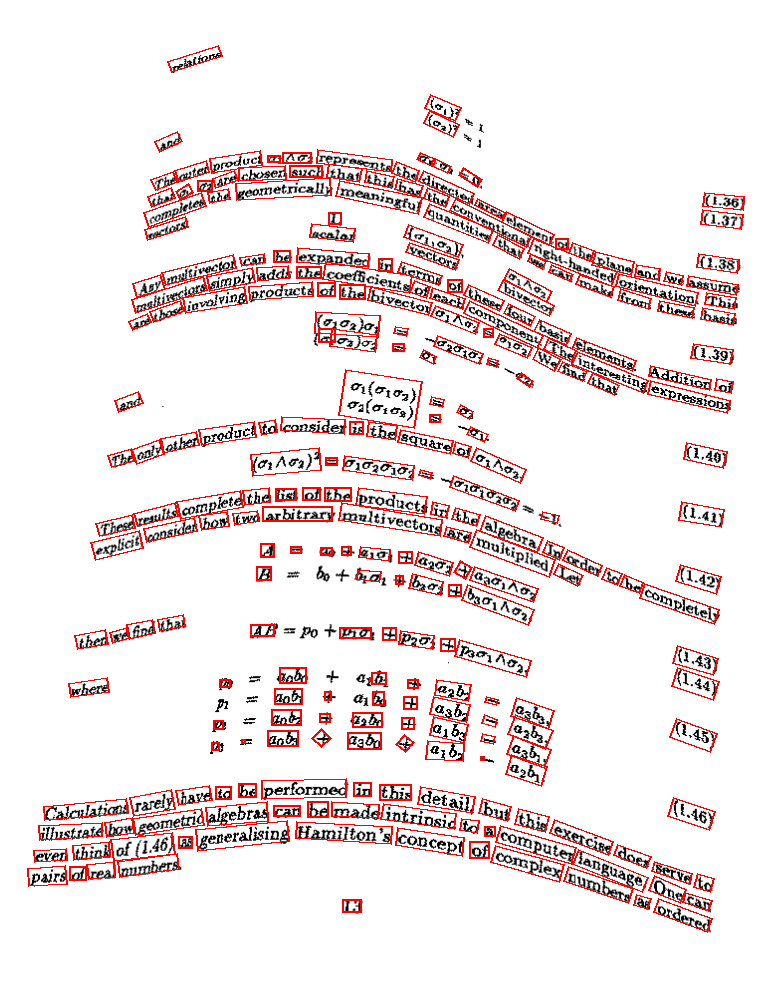

In [ ]:
# ROTATED

words_dim = []
image = Image.open(image_paths[i])
draw = ImageDraw.Draw(image)
width, height = image.size
ratio = max(width, height)
words[:, :, :] *= ratio
# words[:, :, 1] *= ratio
words_dim_rotated = []

for points in words:
    # p = [points[0], points[1], points[2], points[3]]
    # draw.rectangle([x1*width, y1*height, x2*width, y2*height], outline='red', width=2)
    draw.polygon(points, outline='red', width=2)
    words_dim_rotated.append(points)

display(image)

In [ ]:
img = cv2.imread(image_paths[i])
hm = create_heatmap(words_dim)

In [ ]:
def reorder_coordinates(coordinates):
    ordered_coordinates = []
    for polygon_coords in coordinates:
        most_left_coords = polygon_coords[np.argsort(polygon_coords[:, 0])][:2]
        sorted_most_left_coords = most_left_coords[np.argsort(most_left_coords[:, 1])]
        most_left_top = sorted_most_left_coords[0]
        idx = np.where((polygon_coords == most_left_top).all(axis=1))[0][0]

        reordered_coords = np.roll(polygon_coords, -idx, axis=0)
        ordered_coordinates.append(reordered_coords)
    return ordered_coordinates

def sort_by_y_of_first_coord(polygons):
    def get_y_of_first_coord(polygon):
        return min(point[1] for point in polygon)
    sorted_polygons = sorted(polygons, key=get_y_of_first_coord)
    return sorted_polygons

[[282.875   152.09375]
 [311.9375  152.09375]
 [311.9375  163.71875]
 [282.875   163.71875]]


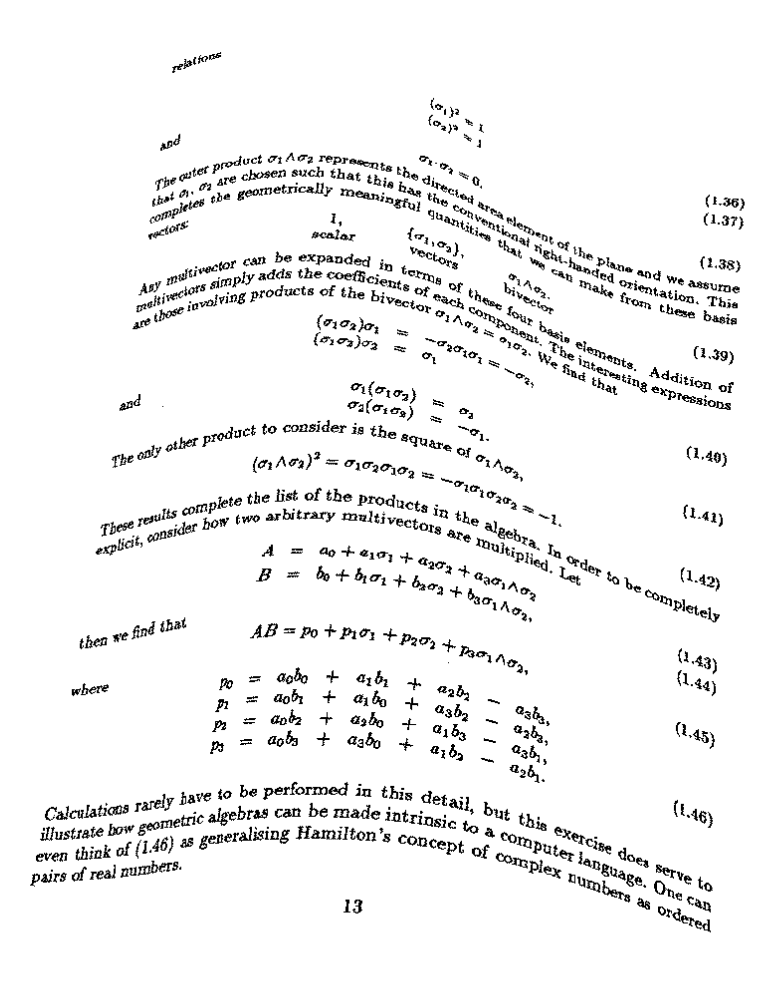

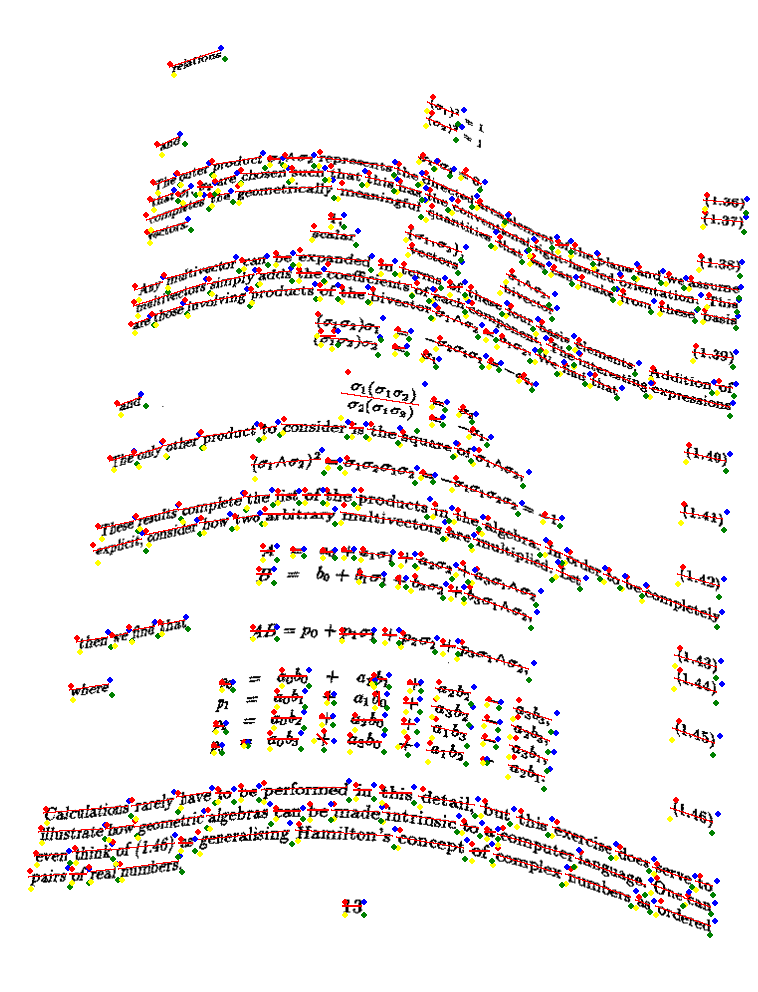

In [ ]:
heatmap = cv2.resize(hm, (img.shape[1], img.shape[0]))
# plt.matshow(heatmap)
# plt.show()
heatmapshow = None
heatmapshow = cv2.normalize(heatmap, heatmapshow, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_HOT)
# cv2_imshow(heatmapshow)

# Grayscale then Otsu's threshold
gray = cv2.cvtColor(heatmapshow, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

ksize = (8, 1)
thresh = cv2.blur(thresh, ksize)
# cv2_imshow(thresh)

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

image_final = Image.open(image_paths[i])
image_middle_line = Image.open(image_paths[i])
draw = ImageDraw.Draw(image_final)
draw_middle_line = ImageDraw.Draw(image_middle_line)
width, height = image_final.size

# cnts = filter_boxes_wh(cnts)
blocks_boxes = []
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(heatmapshow, (x, y), (x + w, y + h), (36,255,12), 2)
    # draw.rectangle([x, y, x + w, y + h], outline='green', width=2)
    blocks_boxes.append([x, y, x + w, y + h])

# blocks_boxes = filter_boxes(blocks_boxes)
blocks_boxes = filter_blocks_th(blocks_boxes, threshold=0.9)
for [x1, y1, x2, y2] in blocks_boxes:
    draw.rectangle([x1, y1, x2, y2], outline='green', width=2)

for points in words_dim_rotated:
    mid1_y1 = (points[0][1] + points[3][1]) // 2
    mid1_y2 = (points[2][1] + points[1][1]) // 2
    mid1_x1 = (points[0][0] + points[3][0]) // 2
    mid1_x2 = (points[2][0] + points[1][0]) // 2

    mid2_y1 = (points[0][1] + points[1][1]) // 2
    mid2_y2 = (points[2][1] + points[3][1]) // 2
    mid2_x1 = (points[0][0] + points[1][0]) // 2
    mid2_x2 = (points[2][0] + points[3][0]) // 2
    d1 = np.sqrt((mid1_x1 - mid1_x2) ** 2 + (mid1_y1 - mid1_y2) ** 2)
    d2 = np.sqrt((mid2_x1 - mid2_x2) ** 2 + (mid2_y1 - mid2_y2) ** 2)
    if(d1 >= d2):
      mid_y1 = mid1_y1
      mid_y2 = mid1_y2
      mid_x1 = mid1_x1
      mid_x2 = mid1_x2
    else:
      mid_y1 = mid2_y1
      mid_y2 = mid2_y2
      mid_x1 = mid2_x1
      mid_x2 = mid2_x2
    # print(f'{d1}, {d2}')
    draw_middle_line.line((mid_x1, mid_y1, mid_x2, mid_y2), fill='red', width=2)

ordered_polygons = reorder_coordinates(words_dim_rotated)

for p in ordered_polygons:
  # print(polygon[0])
  draw_middle_line.ellipse([(p[0][0],p[0][1]),(p[0][0]+5,p[0][1]+5)], fill="red")
  draw_middle_line.ellipse([(p[1][0],p[1][1]),(p[1][0]+5,p[1][1]+5)], fill="blue")
  draw_middle_line.ellipse([(p[2][0],p[2][1]),(p[2][0]+5,p[2][1]+5)],  fill="green")
  draw_middle_line.ellipse([(p[3][0],p[3][1]),(p[3][0]+5,p[3][1]+5)],  fill="yellow")
p = ordered_polygons[-5]
print(p)
# draw_middle_line.ellipse([(p[0][0],p[0][1]),(p[0][0]+5,p[0][1]+5)], fill="pink")
# draw_middle_line.ellipse([(p[1][0],p[1][1]),(p[1][0]+5,p[1][1]+5)], fill="pink")
# draw_middle_line.ellipse([(p[2][0],p[2][1]),(p[2][0]+5,p[2][1]+5)],  fill="pink")
# draw_middle_line.ellipse([(p[3][0],p[3][1]),(p[3][0]+5,p[3][1]+5)],  fill="pink")

# cv2_imshow(thresh)
# cv2_imshow(heatmapshow)
img_name = os.path.basename(image_paths[i])
# image_final.save(f'/content/result/{img_name}')
display(image_final)
display(image_middle_line)
# print(result[0])

In [ ]:
def get_xy_maxmin(box):
  tl, tr, br, bl = box[0],box[1],box[2],box[3]
  x_min, x_max = min(tl[0],tr[0],br[0],bl[0]), max(tl[0],tr[0],br[0],bl[0])
  y_min, y_max = max(tl[1],tr[1],br[1],bl[1]), min(tl[1],tr[1],br[1],bl[1])
  return x_min, x_max, y_min, y_max

def find_overlaped_y(box_index, boxes):
    overlapping_boxes = []
    box = boxes[box_index]
    tl, tr, br, bl = box[0],box[1],box[2],box[3]
    target_x_min, target_x_max, target_y_min, target_y_max = get_xy_maxmin(box)
    target_dist_x = target_x_max-target_x_min

    for idx, b in enumerate(boxes):
        if idx != box_index:
            x_min, x_max, y_min, y_max = get_xy_maxmin(b)
            # dist_x = x_max-x_min
            if check_overlapping_y(y_min, y_max,target_y_min ,target_y_max):  #(y_min >= target_y_max and y_min <= target_y_min) or (y_max >= target_y_max and y_max <= target_y_min) or (y_max <= target_y_max and y_min >= target_y_min):
                overlapping_boxes.append(idx)
    return overlapping_boxes

def check_overlapping_y(y1_min, y1_max, y2_min, y2_max):
  if (y1_min >= y2_max and y1_min <= y2_min) or (y1_max >= y2_max and y1_max <= y2_min) or (y1_max <= y2_max and y1_min >= y2_min): return True
  else: return False


def check_x_overlap(box1, box2, thr=0.08):
  x1_min, x1_max, _, __ = get_xy_maxmin(box1)
  x2_min, x2_max, _, __ = get_xy_maxmin(box2)
  if max(x1_min, x2_min) <= min(x1_max, x2_max):
        overlap_length = min(x1_max, x2_max) - max(x1_min, x2_min)
  else: overlap_length = 0
  overlap_coof = overlap_length / (x1_max - x1_min)
  if overlap_coof > thr: return False
  else: return True


def choose_lr_boxes(box_index, overlaped_boxes_idx, boxes):
  main_box = boxes[box_index]
  x1_min, x1_max, _, __ = get_xy_maxmin(main_box)
  # lb = None
  # rb = None
  # lb_x_max = None
  # rb_x_min = None
  # lb_idx = None
  # rb_idx = None
  lb, rb, lb_x_max, rb_x_min, lb_idx, rb_idx = [None] * 6
  tl1, tr1,br1, bl1  = main_box[0], main_box[1],main_box[2], main_box[3]
  word_height = bl1[1] - tl1[1]
  for idx in overlaped_boxes_idx:
        box = boxes[idx]
        if check_x_overlap(main_box, box):
            x_min, x_max, _, __ = get_xy_maxmin(box)
            tr, br  = box[1],box[2]
            dist_l = distance_between_points(tr, tl1) + distance_between_points(br, bl1)
            tl, tr, br, bl  = box[0],box[1],box[2],box[3]
            dist_r = distance_between_points(tl, tr1) + distance_between_points(bl, br1)
            if (x_max < x1_max) and (word_height*3>dist_l) and check_overlapping_y(br[1], tr[1], bl1[1] ,tl1[1]):
                # if lb is None or x_max > lb_x_max:
                if lb is None or dist_l < lb_dist:
                    lb = box
                    # lb_x_max = max(lb[0][0],lb[1][0],lb[2][0],lb[3][0])
                    lb_dist = dist_l
                    lb_idx = idx
            elif (x_min > x1_min) and (word_height*3>dist_r) and check_overlapping_y(bl[1], tl[1], br1[1] ,tr1[1]):
                # if rb is None or x_min < rb_x_min:
                if rb is None or dist_r < rb_dist:
                    rb = box
                    # rb_x_min = min(rb[0][0],rb[1][0],rb[2][0],rb[3][0])
                    rb_dist = dist_r
                    rb_idx = idx
  return lb, lb_idx, rb, rb_idx

def choose_l_box(box_index, overlaped_boxes_idx, boxes):
  main_box = boxes[box_index]
  x1_min, x1_max, _, __ = get_xy_maxmin(main_box)
  lb = None
  lb_x_max = None
  lb_idx = None
  tl1, bl1  = main_box[0],main_box[3]
  word_height = bl1[1] - tl1[1]
  for idx in overlaped_boxes_idx:
            box = boxes[idx]
            # if check_x_overlap(main_box, box):
            x_min, x_max, _, __ = get_xy_maxmin(box)
            tr, br  = box[1],box[2]
            dist = distance_between_points(tr, tl1) + distance_between_points(br, bl1)
            # print(f'{word_height*100}, {dist} ')
            if (x_max < x1_max) and (word_height*3>dist):
                if lb is None or dist < lb_dist:
                    lb = box
                    lb_dist = dist
                    lb_idx = idx
  return lb, lb_idx

def choose_r_box(box_index, overlaped_boxes_idx, boxes):
  main_box = boxes[box_index]
  x1_min, x1_max, _, __ = get_xy_maxmin(main_box)
  rb = None
  rb_x_min = None
  rb_idx = None
  tr1, br1  = main_box[1],main_box[2]
  word_height = br1[1] - tr1[1]
  for idx in overlaped_boxes_idx:
            box = boxes[idx]
        # if check_x_overlap(main_box, box):
            x_min, x_max, _, __ = get_xy_maxmin(box)
            tl, bl  = box[0],box[3]
            dist = distance_between_points(tl, tr1) + distance_between_points(bl, br1)
            if( x_min > x1_min) and (word_height*3>dist):
                if rb is None or dist < rb_dist:
                    rb = box
                    rb_dist = dist
                    rb_idx = idx
  return rb, rb_idx

def delete_elements_by_indexes(lst, indxs):
    indxs.sort(reverse=True)
    for index in indxs:
        del lst[index]

def distance_between_points(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

In [ ]:
ordered_polygons_top = sort_by_y_of_first_coord(ordered_polygons)
# ordered_polygons_top[:9]

In [ ]:
ordered_polygons_top

In [ ]:
lines = []
# lines_indexes = []
line_indexes = []
while ordered_polygons_top:
  top_box = ordered_polygons_top[0]
  tb_overl_idx = find_overlaped_y(0, ordered_polygons_top)
  first_l, idx_l, first_r, idx_r = choose_lr_boxes(0, tb_overl_idx, ordered_polygons_top)
  print(first_l)
  line = [top_box]
  line_indexes = [0]
  while first_l is not None:
    line.insert(0, first_l) #append(first_l)
    line_indexes.append(idx_l)
    l_overl_idx = find_overlaped_y(idx_l, ordered_polygons_top)
    first_l, idx_l = choose_l_box(idx_l, l_overl_idx, ordered_polygons_top)
  while first_r is not None:
    line.append(first_r)
    line_indexes.append(idx_r)
    r_overl_idx = find_overlaped_y(idx_r, ordered_polygons_top)
    first_r, idx_r = choose_r_box(idx_r, r_overl_idx, ordered_polygons_top)
  lines.append(line)
  # lines_indexes.append(line_indexes)
  delete_elements_by_indexes(ordered_polygons_top, line_indexes)
  # ordered_polygons_top = []

In [ ]:
# line_indexes

In [ ]:
# for k in line_indexes:
#   p = ordered_polygons_top[k]
#   draw_middle_line.ellipse([(p[0][0],p[0][1]),(p[0][0]+5,p[0][1]+5)], fill="pink")
#   draw_middle_line.ellipse([(p[1][0],p[1][1]),(p[1][0]+5,p[1][1]+5)], fill="pink")
#   draw_middle_line.ellipse([(p[2][0],p[2][1]),(p[2][0]+5,p[2][1]+5)],  fill="pink")
#   draw_middle_line.ellipse([(p[3][0],p[3][1]),(p[3][0]+5,p[3][1]+5)],  fill="pink")

# p = ordered_polygons_top[11]
# draw_middle_line.ellipse([(p[0][0],p[0][1]),(p[0][0]+5,p[0][1]+5)], fill="pink")
# draw_middle_line.ellipse([(p[1][0],p[1][1]),(p[1][0]+5,p[1][1]+5)], fill="pink")
# draw_middle_line.ellipse([(p[2][0],p[2][1]),(p[2][0]+5,p[2][1]+5)],  fill="pink")
# draw_middle_line.ellipse([(p[3][0],p[3][1]),(p[3][0]+5,p[3][1]+5)],  fill="pink")
# display(image_middle_line)

In [ ]:
lines[4]

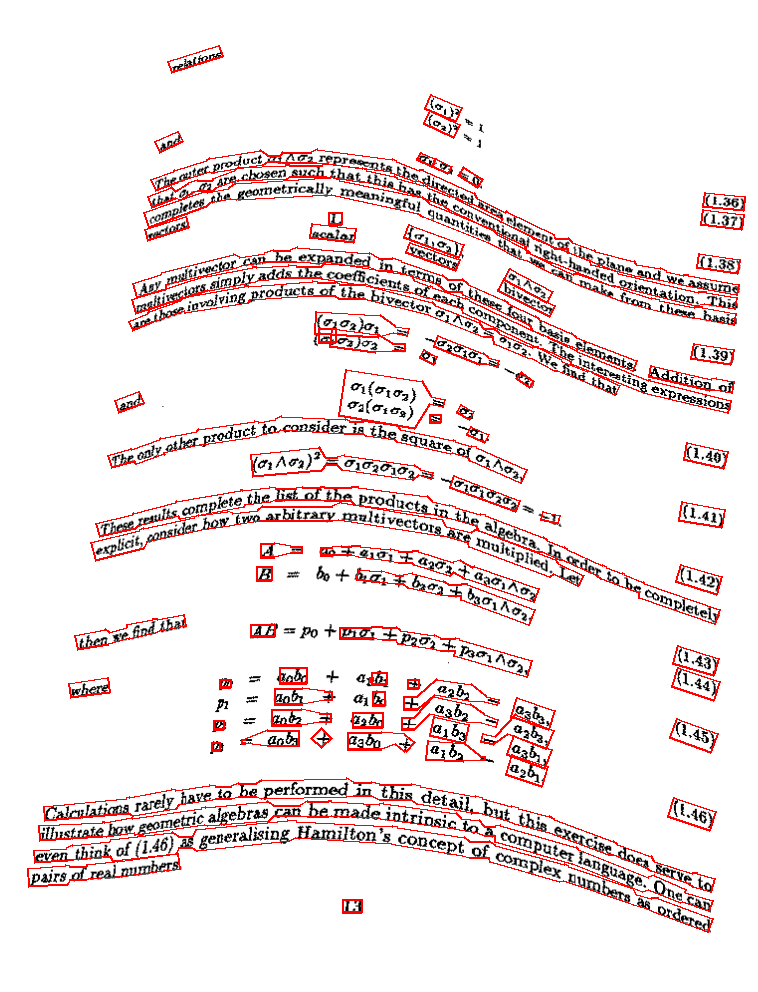

In [ ]:
image_result = Image.open(image_paths[i])
draw_result = ImageDraw.Draw(image_result)

for line in lines:
  first_word = line[0]
  draw_result.line((first_word[0][0], first_word[0][1], first_word[3][0], first_word[3][1]), fill='red', width=2)
  tr_point = first_word[1]
  br_point = first_word[2]
  last_word = line[-1]
  draw_result.line((last_word[1][0], last_word[1][1], last_word[2][0], last_word[2][1]), fill='red', width=2)
  for points in line:
        draw_result.line((points[0][0], points[0][1], points[1][0], points[1][1]), fill='red', width=2)
        draw_result.line((points[2][0], points[2][1], points[3][0], points[3][1]), fill='red', width=2)
        draw_result.line((points[0][0], points[0][1], tr_point[0], tr_point[1]), fill='red', width=2)
        draw_result.line((points[3][0], points[3][1], br_point[0], br_point[1]), fill='red', width=2)
        tr_point = points[1]
        br_point = points[2]
display(image_result)

## f

In [ ]:
# Define colors for different clusters (optional)
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # RGB colors for clusters

# Iterate over each cluster
for cluster_id in np.unique(coordinates[:, -1]):
    # Filter coordinates belonging to the current cluster
    cluster_coords = coordinates[coordinates[:, -1] == cluster_id][:, :4]

    # Calculate the minimum and maximum coordinates of the bounding boxes in the cluster
    min_x = np.min(cluster_coords[:, 0])
    min_y = np.min(cluster_coords[:, 1])
    max_x = np.max(cluster_coords[:, 2])
    max_y = np.max(cluster_coords[:, 3])

    # Draw a rectangle around the cluster
    draw.rectangle([(min_x, min_y), (max_x, max_y)], outline=colors[cluster_id])

# Show the image
image.show()

# CLUSTERS

# coordinates = []
# coordinates = sorted(words_dim, key=lambda x: x[3])
# coordinates = np.array(coordinates)
# previous_y2 = np.roll(coordinates[:, 3], 1)
# previous_y2[0] = coordinates[0, 3]  # Replace the first element with the second
# distance = coordinates[:, 3] - previous_y2
# indices = np.where(distance > 0.002 * coordinates[:, 3].mean())[0]
# clusters = np.zeros_like(coordinates[:, 3], dtype=int)
# current_cluster = 0
# for idx in indices:
#     clusters[idx:] = current_cluster
#     current_cluster += 1


# coordinates = np.column_stack((coordinates, clusters))

# for [x1, y1, x2, y2] in result:
#     if cl==0:
#       mid_y = (y1 + y2) // 2
#       draw_middle_line.line((x1, mid_y, x2, mid_y), fill='green', width=2)

# for cluster_id in np.unique(coordinates[:, -1]):
#     cluster_coords = coordinates[coordinates[:, -1] == cluster_id][:, :4]

#     min_x = np.min(cluster_coords[:, 0])
#     min_y = np.min(cluster_coords[:, 1])
#     max_x = np.max(cluster_coords[:, 2])
#     max_y = np.max(cluster_coords[:, 3])

#     draw_middle_line.rectangle([(min_x, min_y), (max_x, max_y)], outline='green', width=2)

array([[4.18500000e+02, 5.62500000e+01, 4.60156250e+02, 7.12500000e+01,
        6.64318621e-01, 0.00000000e+00],
       [3.71031250e+02, 5.87500000e+01, 4.19468750e+02, 7.25000000e+01,
        6.93544447e-01, 0.00000000e+00],
       [2.48000000e+02, 6.12500000e+01, 2.69312500e+02, 7.75000000e+01,
        6.61875427e-01, 0.00000000e+00],
       ...,
       [1.27875000e+02, 1.20625000e+03, 1.85031250e+02, 1.22875000e+03,
        6.68876827e-01, 3.00000000e+00],
       [8.42812500e+01, 1.20625000e+03, 1.29812500e+02, 1.23000000e+03,
        6.92398012e-01, 3.00000000e+00],
       [4.96968750e+02, 1.22375000e+03, 5.27000000e+02, 1.24500000e+03,
        7.60536611e-01, 4.00000000e+00]])